<a href="https://colab.research.google.com/github/cikufa/lateralcontrol_1/blob/shekoufeh/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# libraries
#choko
#tasks: 1-action , preview dist in in reward/ 2- one step ahead in network input/ 3- reward every 5 iteration 
import numpy as np 
import math
import matplotlib.pyplot as plt
import shapely.geometry as geom
from shapely.ops import nearest_points
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import adam_v2
import tensorflow_probability as tfp
import os
from keras.layers import Dense
!pip install xlsxwriter
import xlsxwriter
#from keras.optimizers import adam
from google.colab import drive
drive.mount('/content/drive')
!ls

     |████████████████████████████████| 149 kB 5.9 MB/s 
Mounted at /content/drive
drive  sample_data


In [ ]:
class GenericNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims, fc2_dims, name, chkpt_dir="/tmp/actor_critic"):
        super(GenericNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.fc3 = Dense(n_actions)
        
        #self.v = Dense(1, activation=None)
        #continous action is represented as a normal distribution that is characterized with 2 quantities: a mean and a standard deviation 
        #self.pi = Dense(n_actions=2, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
class Agent:
    def __init__(self, layer1_dim=128, layer2_dim=64, n_actions=2, alpha_A=0.00003, alpha_C=0.00005, gamma=0.99):
        self.layer1_dim = layer1_dim
        self.layer2_dim = layer2_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha_A = alpha_A 
        self.alpha_C= alpha_C
        self.action = None
        self.log_prob= None
        
        self.actor = GenericNetwork(n_actions, layer1_dim, layer2_dim, "actor")
        self.actor.compile(optimizer=adam_v2.Adam(learning_rate=alpha_A))
        self.critic = GenericNetwork(1, layer1_dim, layer2_dim, "critic")
        self.critic.compile(optimizer=adam_v2.Adam(learning_rate=alpha_C))
        self.aloss= []
        self.closs=[]

    def choose_action(self, observation): #obs shape (1,2)
        state = tf.convert_to_tensor([observation]) #state shape (1,1,2)
        pars= self.actor(state) #mean and standard deviation that make action probs
        pars= np.asarray(tf.squeeze(pars)).reshape(1,2)  
        sigma , mu = np.hsplit(pars , 2)
        sigma = tf.exp(sigma) #get rid of negative sigma
        #sigma= abs(sigma)
        action_probabilities = tfp.distributions.Normal(mu , sigma) #normal distribution with mu,sigma pars  
        #log_prob = action_probabilities.log_prob(action_probabilities) #log (gonna be used for gradient)
        action = action_probabilities.sample() #choose action (most likely to be chosen with higher probability)
        action = tf.tanh(action) * 0.07 #action: continuous num in range(-0.07, 0.07)((-4,4) degree_
        self.action = action  
        return action #cast tensor to numpy(openAI gym doesnt take tensor)

    def save_models(self):
        #print('... saving models ...')
        self.actor.save_weights(self.actor.checkpoint_file)
        self.critic.save_weights(self.critic.checkpoint_file)
    def load_models(self):
        print('... loading models ...')
        self.actor.load_weights(self.actor.checkpoint_file)
        self.critic.load_weights(self.critic.checkpoint_file)
        
    def learn(self, state, reward, state_,done):
        #print("state before ")
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32) # not fed to NN -> no need to reshape
        with tf.GradientTape(persistent=True) as tape:
            state_value = self.critic(state)
            state_value_ = self.critic(state_)
            state_value = tf.squeeze(state_value) #squeeze Removes dims of size 1 from the shape of a tensor.
            state_value_ = tf.squeeze(state_value_)
            pars= self.actor(state)
            #pars= np.asarray(tf.squeeze(pars)).reshape(1,2)
            #mu , sigma= np.hsplit(pars , 2)
            #mu = np.squeeze(mu)
            #sigma = np.squeeze(sigma)
            mu = pars[0,0]
            sigma = pars[0,1]
            #print(sigma)
            #sigma = tf.exp(sigma)
            #print(sigma)
            action_probs = tfp.distributions.Normal(mu, abs(sigma)) #policy 
            log_prob = action_probs.log_prob(self.action[0,0] )
            #print(mu,sigma)
            #print(log_prob)
                      
            #TD error: 
            TD= self.gamma*state_value_*(1-int(done)) - state_value 
            delta = reward + TD #1-done: terminal stRemoves dimensions of size 1 from the shape of a tensor.ate zero effect 
            actor_loss = (-log_prob*delta)            
            critic_loss = (delta**2) 
            #print("sig", sigma , "ac", actor_loss, "cr", critic_loss)
  
            
        gradient1 = tape.gradient(actor_loss, self.actor.trainable_variables)
        
        self.actor.optimizer.apply_gradients((grad , var) for (grad , var) in zip(gradient1, self.actor.trainable_variables) if grad is not None)
        #if grad is not None
            
        gradient2 = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients((grad , var) for (grad , var) in zip(gradient2, self.critic.trainable_variables) if grad is not None)
        # if grad is not None
        return critic_loss, actor_loss, gradient1


In [ ]:
from numpy import genfromtxt
class lateralenv:
    def __init__(self, roadfile, data_length , n_episodes, episode_length):
        #constants
        dt=0.1
        vx=10
        iz= 2278.8
        m=1300
        a1=1; a2=1.5
        caf = 60000; car= 60000
        cb= -(caf + car); cr= (-a1*caf + a2*car)/ vx
        db= -(a1* caf - a2*car); dr= -(a1**2 *caf + a2**2*car) / vx
        cd = caf; dd= a1*caf
        self.constants=[dt, vx, iz, m, cb, cr, db, dr, cd, dd]

        self.data_length = data_length 
        self.n_episodes = n_episodes 
        self.episode_length=episode_length
        self.episode_length_cnt =episode_length
        
        #x = np.linspace(0, 10*math.pi, 20000).reshape(20000,1) #0<x<314
        x= np.arange(0, self.data_length).reshape(self.data_length, 1) 
        y= 50*np.sin(x/200)
        self.road = geom.LineString(zip(x,y))
        
        #self.road = genfromtxt(roadfile, delimiter=',')
        
        heading_angle = [np.arctan2(y[i+1]-y[i] , x[i+1]-x[i]) for i in range(y.shape[0]-1)] #rad #56.3
        heading_angle.insert(0,heading_angle[0]) #append last value to adjust the shape          _____EDITED_____        
        heading_angle= np.asfarray(heading_angle).reshape(self.data_length,1)

        #print('_psiiiiiii', heading_angle[0])

        #init vars
        self.vy0=0; self.r0=0; self.x0= 3; self.y0= 0; self.psi0= 0.27 #self.psi0= heading_angle[0] 
        
        self.vars0= np.array([[self.vy0, self.r0, self.x0, self.y0, self.psi0]], dtype='float64').T #1,5 vars0
        self.vars= self.vars0
        self.vars_= np.zeros((5,1))
        self.score = 0
        self.index=0
        self.Done=0
        self.coordinates=[]
        self.vys = []
        self.vymax = -10

        point0 = geom.Point(self.x0, self.y0)
        dist0, angle_diff0, _ = self.dist_diff(point0, 0, limit= 1) # sefr alaki 
        future_point0= self.preview(point0)
        future_dist0 , future_ang0 , _ = self.dist_diff(future_point0, 0, limit=1) # sefr alaki
        self.state0= np.array([dist0, angle_diff0]) #(1,2)
        #self.state0= np.array([dist0, angle_diff0, future_dist0, future_ang0]) #(1,4)
        #print("state0 = ", self.state0)
       
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    def dist_diff(self, point,ep, limit):
        ##1: based on where the car is supposed to be on this iteration
        #self.index = self.index+1
        #dist = self.data[self.index, 0:2] - coordinate_ #(1,2)
        #angle_diff= self.data[self.index,2] - psi_  
        #________________________________________________________________________
        
        ## 2: based on where the car is supposed to be if the driven distance was along the road
        # driving_distance= (vy**2 + vx**2)**0.5 *dt #driving angle : psi_ 
        # #(dx^2+dy^2)^0.5= distance , dy=1.5dx -> (3.25dx^2)*0.5 = distance -> 1.802 dx = distance
        # dx= driving_distance / math.sqrt(3.25); dy= dx*1.5
        # dist= ((dx - x_)**2 + (dy- y_)**2)**0.5  
        #angle_diff =
         #_______________________________________________________________________

        #3: based on car's vertical disance with the road          
        dist = point.distance(self.road) 
        dist_z = math.sqrt((point.y-self.y0)**2+(point.x-self.x0)**2)
        limited_dist= max(dist, 0.01)
        limited_dist= min(limited_dist, 100)

        nearestP = nearest_points(self.road, point)[0]
        angle_diff= np.arctan2(nearestP.centroid.y, nearestP.centroid.x) - np.arctan2(point.y,point.x) #pos/neg mide        
        limited_angle_diff=max(angle_diff, 0.01)
        limited_angle_diff=min(limited_angle_diff , 100) #-> max reward = 5000, min reward 5e-5
        if (limit==1):
          return limited_dist, limited_angle_diff , dist_z
        else:
          return dist, angle_diff , dist_z


#_______________________________________________________________________________________________________________

    def preview(self, point):
        action = 0
        dt, vx, iz, m, cb, cr, db, dr, cd, dd= self.constants
        vy, r, x, y, psi = np.vsplit(self.vars,5)
        #dt = dt*5 # 5 step forward preview 
        #calc new state
        par_mat1 = np.array([[cb/(m*vx), cr/m-vx,0,0,0],
                           [db/(iz*vx), dr/iz, 0,0,0],
                           [-math.sin(psi),0,0,0,0],
                           [math.cos(psi),0,0,0,0],
                           [0,1,0,0,0]])
        
        par_mat2 = np.array([[cd* action /m],[dd*action/iz], [vx*math.cos(psi)],
                    [vx*math.sin(psi)],[0]], dtype='float64') 
     
        var_dot_mat = par_mat1 @ self.vars + par_mat2  #(5,1)= (5,5)@(5,1)+(5,1)
        self.vars_= self.vars + dt* var_dot_mat #(5,1) =(5,1)+(5,1)
        vy_, r_, x_, y_, psi_= np.vsplit(self.vars_,5)
        future_point= geom.Point(x_, y_)

        return future_point

    def step(self, action,stp_cnt):
       
        dt, vx, iz, m, cb, cr, db, dr, cd, dd= self.constants
        vy, r, x, y, psi = np.vsplit(self.vars,5)
        
        #calc new state
        par_mat1 = np.array([[cb/(m*vx), cr/m-vx,0,0,0],
                           [db/(iz*vx), dr/iz, 0,0,0],
                           [-math.sin(psi),0,0,0,0],
                           [math.cos(psi),0,0,0,0],
                           [0,1,0,0,0]])
        
        par_mat2 = np.array([[cd* action /m],[dd*action/iz], [vx*math.cos(psi)],
                    [vx*math.sin(psi)],[0]], dtype='float64') 
     
        var_dot_mat = par_mat1 @ self.vars + par_mat2  #(5,1)= (5,5)@(5,1)+(5,1)
        self.vars_= self.vars + dt* var_dot_mat #(5,1) =(5,1)+(5,1)
        vy_, r_, x_, y_, psi_= np.vsplit(self.vars_,5)
        #print("vy , vy_", self.vars[0], self.vars_[0])
        # if self.vars_[0] > self.vymax:
        #     self.vymax = self.vars_[0]
#        print("max vy: ", self.vymax)

        point = geom.Point(x_, y_)
        #print("pppppppppp", point)
        dist, ang_diff, dist_z = lateralenv.dist_diff(self,point,ep, limit=0)
        #print("diiiiiiiiiif", dist, ang_diff)
        future_point= lateralenv.preview(self, point)
        future_dist , future_ang , _ = lateralenv.dist_diff(self, future_point, ep, limit=0)
          
        '''dist = point.distance(self.road) 
        limited_dist= max(dist, 0.01)
        limited_dist= min(limited_dist, 100)

        nearestP = nearest_points(self.road, point)[0]
        angle_diff= np.arctan2(nearestP.centroid.y, nearestP.centroid.x) - np.arctan2(y_,x_)[0] #pos/neg mide
        limited_angle_diff=max(angle_diff, 0.01)
        limited_angle_diff=min(limited_angle_diff , 100) #-> max reward = 5000, min reward 5e-5'''

        #action_weight = 10      
        #preview_weight = 0.01
        #reward = 1/(dist**2 + ang_diff**2) # + preview_weight/(future_dist**2 + future_ang**2) #+ action * action_weight
        reward = 1/(dist + ang_diff)
        #print("dist", dist, "ang", ang_diff, "reward", reward)
        #reward = 5

        # if dist > 2:
        #     makhraj = -1/dist
        # #try: 
        # else:
        #     min = 1e-1
        #     max = 1e+1
        #     makhraj= abs(dist)**2 if abs(dist)**2 > min else min #max reward= 10
            
        '''except OverflowError as err:
            makhraj = max #min reward = 0.1'''

        #reward = dist_z/(stp_cnt+1)
        reward = - dist_z/10

        #for next step
        self.coordinates.append(self.vars[2:4,0])
        self.vys.append(self.vars[0])
        self.vars = self.vars_ 
        #self.state_ = np.hstack((dist, ang_diff, future_dist, future_ang)) #real state (not limited)
        self.state_ = np.hstack((dist, ang_diff)) #real state (not limited)

        #self.futurestate_ = np.hstack((future_dist, future_ang)) #real state (not limited)
 
        self.episode_length_cnt = self.episode_length_cnt -1
        
        if self.episode_length_cnt==0: 
            self.Done = 1

        return  self.state_, reward, self.Done,  #state:(dist, ang_dif)

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    def render(self, ep, score):
        #plt.subplot(1,2,2)
        #worksheet.write(ep+1, 0, int(aloss))
        #worksheet.write(ep+1, 1, int(closs))
        #worksheet.write(ep+1, 2, score) 
        
        plt.xlabel("x")
        plt.ylabel("y")
        
        plt.plot(self.road.coords.xy[0][0:int(self.episode_length)*3], self.road.coords.xy[1][0:int(self.episode_length)*3],'r') #road 
        plt.plot(np.array(self.coordinates)[:,0], np.array(self.coordinates)[:,1], label =score) #path
        plt.legend()
        if (ep%10 == 0):
          # plt.xlabel("x")
          # plt.ylabel("y")
          # plt.plot(self.data[0:self.episode_length*2, 0], self.data[0:self.episode_length*2,1],'r') #road 
          # plt.plot(np.array(self.coordinates)[:,0], np.array(self.coordinates)[:,1], label =score) #path
          # plt.legend()
          plt.savefig(f"drive/MyDrive/RL paper/path{ep}.jpg")
          plt.cla() 
          #if (ep%50 ==0):
                
        pass
    
    def reset(self): # before each episode 
        self.Done= 0
        self.episode_length_cnt = self.episode_length 
        
        p = geom.Point(self.vars_[2,0], self.vars_[3,0])
        #init_coord = nearest_points(self.road, p)[0]
        #self.state = np.hstack((init_coord, math.atan(1.5)))
        #self.state = np.array([[0,0,math.atan(1.5)]]) #shape(1,3)
        
        self.vars= self.vars0
        self.coordinates = []
        return self.state0


episode  1 score -12524.999999999976 avg_score -12524.999999999976 reward -49.999999999999694
episode  2 score -12524.999999999976 avg_score -12524.999999999976 reward -49.999999999999694
episode  3 score -12524.999999999976 avg_score -12524.999999999976 reward -49.999999999999694
episode  4 score -12524.999999999976 avg_score -12524.999999999976 reward -49.999999999999694
episode  5 score -12524.999999999976 avg_score -12524.999999999976 reward -49.999999999999694
episode  6 score -12524.999999999976 avg_score -12524.999999999976 reward -49.999999999999694
episode  7 score -12524.999999999976 avg_score -12524.999999999975 reward -49.999999999999694
episode  8 score -12524.999999999976 avg_score -12524.999999999976 reward -49.999999999999694
episode  9 score -12524.999999999976 avg_score -12524.999999999976 reward -49.999999999999694
episode  10 score -12524.999999999976 avg_score -12524.999999999975 reward -49.999999999999694
episode  11 score -12524.999999999976 avg_score -12524.9999

KeyboardInterrupt: ignored

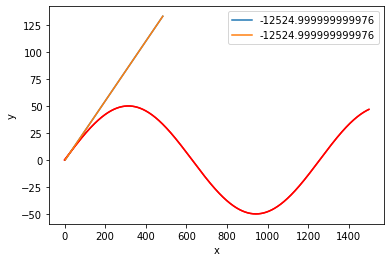

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#if __name__ == '__main__':
agent = Agent(layer1_dim=128, layer2_dim=64, n_actions=2, alpha_A=0.0003, alpha_C=0.005, gamma=0.99)
n_episodes = 100
data_length= 50000
ep_length = int(data_length/n_episodes)
roadfile = 'drive/MyDrive/RL paper/RealRoad1.csv'
#env = lateralenv(roadfile, data_length, n_episodes, ep_length)
env = lateralenv(roadfile, data_length, n_episodes, ep_length)

score_history = []
best_score = 0 #reward = 1/positive > 0 -> min score =0    
load_checkpoint = False 
if load_checkpoint:
    agent.load_models()

#data_path= os.path.join(os.path.abspath(os.getcwd()), "/Road Samples")
workbook = xlsxwriter.Workbook('drive/MyDrive/RL paper/log.xlsx')
log = workbook.add_worksheet("ep_per_ep")
log.write(0,0,"ep / step")
log.write(0,1,"actor loss")
log.write(0,2,"critic loss")
log.write(0,3,"reward")
log.write(0,4,"distance")
log.write(0,5,"angle_diff")

#training________________________________________________________________________________________
cnt=0
for ep in range(1, n_episodes+1): 
    #file= open("/%d.csv".format(i//4))  
    #roadxy = np.loadtxt(file, delimiter=" ")
    #observation = roadxy[roadxy.shape[0]/4*i%4,roadxy.shape[0]//4*(i%4+1)]
    #data_chunk = env.data[episode_length * i:episode_length * (i+1) , :]
    score=0
    al = []; cl=[]; rewards=[]
    state = env.reset() #(1,2)
    #for j in range(2):
    j=0
    states_=[]
    while not env.Done:
        action = agent.choose_action(state)
        #print("action", action)
        state_, reward, Done = env.step(action,j)
        #print("reward", reward)
        states_.append(state_)
        
        #with open('rewards.txt', 'a') as f:
            #writer = csv.writer(f)
            #writer.writerow(str(reward))
            #f.write(str(j)+" "+str(reward)+"\n")
          #print(j, "reward :", reward)
        
        score = score + reward
        rewards.append(reward)

        #if not load_checkpoint:
        closs, aloss, grad1= agent.learn(state, reward, state_, Done)
        #log
        log.write((ep-1)*ep_length + j+1, 0, f"{ep} / {j}")
        log.write((ep-1)*ep_length + j+1, 1, str(closs))
        log.write((ep-1)*ep_length + j+1, 2, str(aloss))
        log.write((ep-1)*ep_length + j+1, 3, reward)
        log.write((ep-1)*ep_length + j+1, 4, state_[0])
        log.write((ep-1)*ep_length + j+1, 5, state_[1])
        #log.write((ep-1)*ep_length + j+1, 6, int(grad1))

        state = state_
        j+=1 #step counter
        #print(state_)

    states_ = np.array(states_)
    # m=np.min(states_, axis=0)
    # M=np.max(states_, axis=0)
    # print("episode ", j, "min", m, "max", M)
    
    #print("max", states_[0].max())
    score_history.append(score)
  
        #______________ plot score curve)
        # ep = [i+1 for i in range(i)]
        # x= np.array(ep).reshape(i,1)
        # #score_history= np.array(score_history).reshape(i,1)
        # plt.xlabel("episode")
        # plt.ylabel("score")
        # plt.plot(x, np.array(score_history).reshape(i,1))
        # plt.savefig(figure_file)

    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()
    if (ep%1==0):
        print('episode ', ep, 'score' ,score, 'avg_score' ,avg_score, 'reward', reward)
        env.render(ep, score)
   
workbook.close()

if not load_checkpoint:
    ep = [i+1 for i in range(n_episodes)]
    x= np.array(ep).reshape(n_episodes,1)
    score_history= np.array(score_history).reshape(n_episodes,1)
    plt.xlabel("episode")
    plt.ylabel("score")
    plt.plot(x, score_history)
    plt.savefig('scores.png')

# New Section

In [ ]:
# test 
import numpy as np 
import math
import shapely.geometry as geom
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

x= np.arange(0, 10).reshape(10, 1) 
y= 50*np.sin(x/200)
road = geom.LineString(zip(x,y))
p= geom.Point(314,50)
dist = p.distance(road) 
print(dist)
nearestP = nearest_points(road, p)
print(nearestP[0])
#angle_diff= np.arctan2(nearestP.centroid.y, nearestP.centroid.x) - self.psi0 #pos/neg mide         
      

308.71529766687416
POINT (9 2.2492407018830116)
